In [275]:
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent

import pandas as pd
import time
import unidecode
from tqdm import tqdm_notebook

from ftfy import fix_text

import pickle

# Кроулер

In [266]:
main_link = "https://krisha.kz/prodazha/kvartiry/astana-esilskij/?das[_sys.hasphoto]=1&das[checked]=1&das[novostroiki]=1&das[who]=1&page="
page_link = "https://krisha.kz/"

In [720]:
responce = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

In [4]:
def get_soup(page_link):
    responce = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    soup = BeautifulSoup(responce.content, "html.parser")
    return soup

In [5]:
soup = get_soup(main_link+str(2))

In [6]:
links_raw = soup.findAll("a", attrs={"a-card__title"})

In [7]:
links = [i["href"] for i in links_raw]

In [8]:
def get_links(page_number):
    soup = get_soup(main_link+str(page_number))
    links_raw = soup.findAll("a", attrs={"a-card__title"})
    links = [i["href"] for i in links_raw]
    return links

In [9]:
get_links(4)

['/a/show/57384754',
 '/a/show/57464356',
 '/a/show/56089229',
 '/a/show/55376811',
 '/a/show/57825571',
 '/a/show/56688229',
 '/a/show/57503858',
 '/a/show/57503879',
 '/a/show/57503772',
 '/a/show/57503826',
 '/a/show/57503793',
 '/a/show/57503872',
 '/a/show/55504624',
 '/a/show/57281498',
 '/a/show/57410926',
 '/a/show/57410626',
 '/a/show/57281611',
 '/a/show/57281581',
 '/a/show/57206703',
 '/a/show/57206245']

## Собираем ссылки

In [272]:
all_links = []
for i in range(553):
    links = get_links(i)
    all_links.extend(links)

all_links = list((set(all_links)))

In [274]:
len(all_links)

10802

## Сохроняем

In [276]:
with open('all_links.pkl', 'wb') as f:
    pickle.dump(all_links, f)

In [277]:
with open('all_links.pkl', 'rb') as f:
    lk = pickle.load(f)

In [279]:
# lk

# Парсер

In [150]:
link = page_link+'a/show/57743274'
main_soup = get_soup("https://krisha.kz/a/show/57300188")

## _get_price

In [254]:
def _get_price(main_soup):
    try:
        price = main_soup.find("div", attrs={'class': 'offer__price'}).text
        price = fix_text(price, normalization='NFKC')
        price = price.replace("〒", "").strip()
        price = price.replace(" ", "").strip()
        price = int(price)
    except:
        price = np.nan
    return price

_get_price(main_soup)

35000000

## _get_rooms

In [256]:
def _get_rooms(main_soup):
    try:
        tittle = main_soup.find("h1")
        tittle = tittle.text.strip()
        tittle = tittle.split(",")[0]
        tittle = tittle.replace("-комнатная квартира", "")
        tittle = int(tittle)
    except:
        tittle = np.nan
    return tittle

_get_rooms(main_soup)

2

## _get_house_name

In [257]:
def _get_house_name(main_soup):
    try:
        house_name = main_soup.find("div", attrs={'data-name': 'map.complex'})
        house_name = house_name.text.replace("Жилой комплекс", "").strip()
    except:
        house_name = np.nan
    return house_name

_get_house_name(main_soup)

'Park Avenue Exclusive'

## _get_square

In [289]:
def _get_square(main_soup):
    try:
        square = main_soup.find("div", {"data-name": "live.square"}).text
        square = [int(s) for s in square.split() if s.isdigit()]
    except:
        square = np.nan
    
    return square

_get_square(main_soup)

[66, 12]

## _get_ceiling

In [259]:
def _get_ceiling(main_soup):
    try:
        ceiling = main_soup.find("div", {"data-name": "ceiling"})
        ceiling = ceiling.text.replace("Потолки", "").replace("м", "").strip()
        ceiling = int(ceiling)
    except:
        ceiling = np.nan
    return ceiling

_get_ceiling(main_soup)

nan

## _get_year_built

In [260]:
def _get_year_built(main_soup):
    try:
        year_built = main_soup.find("div", {"data-name": "flat.building"}).text
        year_built = [int(s) for s in year_built.split() if s.isdigit()][0]
    except:
        year_built = np.nan
    return year_built

_get_year_built(main_soup)

2019

## _get_floor

In [293]:
def _get_floor(main_soup):
    try:
        floor = main_soup.find("div", {"data-name": "flat.floor"})
        floor = floor.text.replace("Этаж", "").strip().split(" из ")
    except:
        floor = np.nan
        
    return floor

_get_floor(main_soup)

['3', '14']

## _get_renovation

In [262]:
def _get_renovation(main_soup):
    try:
        renovation = main_soup.find("div", {"data-name": "flat.renovation"})
        renovation = renovation.text.replace("Состояние", "").strip()
    except:
        renovation = np.nan
    return renovation

_get_renovation(main_soup)

'евроремонт'

## _get_priv_dorm

In [263]:
def _get_priv_dorm(main_soup):
    try:
        priv_dorm = main_soup.find("div", {"data-name": "flat.priv_dorm"})
        priv_dorm = priv_dorm.text.replace("В прив. общежитии", "").strip()
    except:
        priv_dorm = np.nan
    return priv_dorm

_get_priv_dorm(main_soup)

nan

# Сбор данных

In [306]:
def get_page_info(link):
    main_soup = get_soup(page_link + link)
    
    price = _get_price(main_soup)
    priv_dorm = _get_priv_dorm(main_soup)
    renovation = _get_renovation(main_soup)
    floor = _get_floor(main_soup)
    year_built = _get_year_built(main_soup)
    ceiling= _get_ceiling(main_soup)
    square = _get_square(main_soup)
    rooms = _get_rooms(main_soup)
    house_name = _get_house_name(main_soup)
    
    
    info = {
        'price': price,
        'priv_dorm':priv_dorm,
        'renovation':renovation,
        'floor':floor,
        'year_built':year_built,
        'ceiling':ceiling,
        'square':square,
        'rooms':rooms,
        'house_name':house_name,
    }
    
    return info

In [307]:
get_page_info('/a/show/57300188')

{'price': 35000000,
 'priv_dorm': nan,
 'renovation': 'евроремонт',
 'floor': ['3', '14'],
 'year_built': 2019,
 'ceiling': nan,
 'square': [66, 12],
 'rooms': 2,
 'house_name': 'Park Avenue Exclusive'}

In [308]:
news_dataset = pd.DataFrame(columns=['priv_dorm', 'renovation', 'floor', 'year_built', 'ceiling', 'square', 'rooms', 'house_name'])

for link in tqdm_notebook(all_links):
    news_dataset = news_dataset.append(get_page_info(link), ignore_index=True)
    time.sleep(0.1)

In [354]:
news_dataset.to_pickle("news_dataset.pkl")

# Data cleaning

In [504]:
data = news_dataset.copy()

In [505]:
data.price = data.price / 1000000

In [506]:
data = data[data.price.isna()==False]

In [507]:
data.head()

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price
1,NaN,NaN,"[7, 22]",2019,NaN,[42],1,Коркем Tower,15.0000
2,NaN,черновая отделка,"[4, 9]",2020,NaN,[],1,NaN,8.3055
3,NaN,евроремонт,"[4, 10]",2013,NaN,[87],2,Нурсая Бонита,38.0000
4,NaN,хорошее,"[4, 12]",2007,NaN,[70],3,7 Бочек,24.0000
5,NaN,NaN,"[1, 3]",2021,NaN,[8],1,МЖК Астана,5.5980


In [508]:
data.shape

(10534, 9)

In [509]:
news_dataset.ceiling.value_counts()

3     922
28      1
5       1
Name: ceiling, dtype: int64

In [510]:
data.square.fillna("[]", inplace=True)
data.floor.fillna("[]", inplace=True)

In [562]:
square_total, square_living, square_kitchen = [], [], []
for ind, row in data.iterrows():
    if "]" in row["square"]:
        i = []
    else:
        i = row["square"]
        j = int(row["rooms"]) * 30
    square_n = len(i)
    if square_n==0:
        square_total.append(j)
        square_living.append(j * 70 / 100)
        square_kitchen.append(j * 20 / 100)
    elif square_n==1:
        square_total.append(val)
        square_living.append(j * 70 / 100)
        square_kitchen.append(j * 20 / 100)
    elif square_n==2:
        val0 = int()
        val1 = i[1]
        square_total.append(val0)
        square_living.append(val1)
        square_kitchen.append(j * 20 / 100)
    elif square_n==3:
        square_total.append(i[0])
        square_living.append(i[1])
        square_kitchen.append(i[2])
        
data["square_total"] = square_total
data["square_living"] = square_living
data["square_kitchen"] = square_kitchen

In [575]:
floor_flat, floors_total = [], []
for i in data.floor:
    if i == '[]':
        i = []
    floor_n = len(i)
    if floor_n == 0:
        floor_flat.append(np.nan)
        floors_total.append(np.nan)
    elif floor_n==1:
        floor_flat.append(int(i[0]))
        floors_total.append(np.nan)
    elif floor_n==2:
        floor_flat.append(int(i[0]))
        floors_total.append(int(i[1]))
        
data["floor_flat"] = floor_flat
data["floors_total"] = floors_total

In [576]:
data.head()

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,NaN,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,61,21.0,6.0,7.0,22.0,1
2,NaN,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,30,21.0,6.0,4.0,9.0,0
3,NaN,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,61,42.0,12.0,4.0,10.0,7
4,NaN,хорошее,"[4, 12]",2007,2.75,[70],3,7 Бочек,24.0000,61,63.0,18.0,4.0,12.0,13
5,NaN,Unknown,"[1, 3]",2021,2.75,[8],1,МЖК Астана,5.5980,61,21.0,6.0,1.0,3.0,-1


In [577]:
data.year_built = data.year_built.astype(int)

In [578]:
data.rooms = data.rooms.astype(int)

In [580]:
data.ceiling = data.ceiling.fillna(2.75)
data.head(3)

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,NaN,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,61,21.0,6.0,7.0,22.0,1
2,NaN,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,30,21.0,6.0,4.0,9.0,0
3,NaN,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,61,42.0,12.0,4.0,10.0,7


In [581]:
data.house_name.fillna("Unknown", inplace=True)
data.head(3)

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,NaN,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,61,21.0,6.0,7.0,22.0,1
2,NaN,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,30,21.0,6.0,4.0,9.0,0
3,NaN,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,61,42.0,12.0,4.0,10.0,7


In [582]:
data.renovation.fillna("Unknown", inplace=True)
data.head(3)

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,NaN,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,61,21.0,6.0,7.0,22.0,1
2,NaN,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,30,21.0,6.0,4.0,9.0,0
3,NaN,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,61,42.0,12.0,4.0,10.0,7


In [583]:
data["house_age"] = 2020 - data["year_built"].astype(int)
data.head(3)

,priv_dorm,renovation,floor,year_built,ceiling,square,rooms,house_name,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,NaN,Unknown,"[7, 22]",2019,2.75,[42],1,Коркем Tower,15.0000,61,21.0,6.0,7.0,22.0,1
2,NaN,черновая отделка,"[4, 9]",2020,2.75,[],1,Unknown,8.3055,30,21.0,6.0,4.0,9.0,0
3,NaN,евроремонт,"[4, 10]",2013,2.75,[87],2,Нурсая Бонита,38.0000,61,42.0,12.0,4.0,10.0,7


In [584]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10534 entries, 1 to 10801
Data columns (total 15 columns):
priv_dorm         1515 non-null object
renovation        10534 non-null object
floor             10534 non-null object
year_built        10534 non-null int64
ceiling           10534 non-null float64
square            10534 non-null object
rooms             10534 non-null int64
house_name        10534 non-null object
price             10534 non-null float64
square_total      10534 non-null int64
square_living     10534 non-null float64
square_kitchen    10534 non-null float64
floor_flat        9801 non-null float64
floors_total      9615 non-null float64
house_age         10534 non-null int64
dtypes: float64(6), int64(4), object(5)
memory usage: 1.6+ MB


In [585]:
data.drop(["priv_dorm", "floor", "square", "house_name", "year_built"], axis=1, inplace=True)
data.head(3)

,renovation,year_built,ceiling,rooms,price,square_total,square_living,square_kitchen,floor_flat,floors_total,house_age
1,Unknown,2019,2.75,1,15.0000,61,21.0,6.0,7.0,22.0,1
2,черновая отделка,2020,2.75,1,8.3055,30,21.0,6.0,4.0,9.0,0
3,евроремонт,2013,2.75,2,38.0000,61,42.0,12.0,4.0,10.0,7


# EDA

In [503]:
data.house_name.value_counts().to_frame("cnt").sort_values(by="cnt" , ascending=False).head(10)

,cnt
Nova City,300
Венский квартал,151
Арнау,146
Adal,138
College,137
Panorama Park,134
Manhattan,134
Sezim Qala,133
Времена года. Лето,132
Only Sun,128


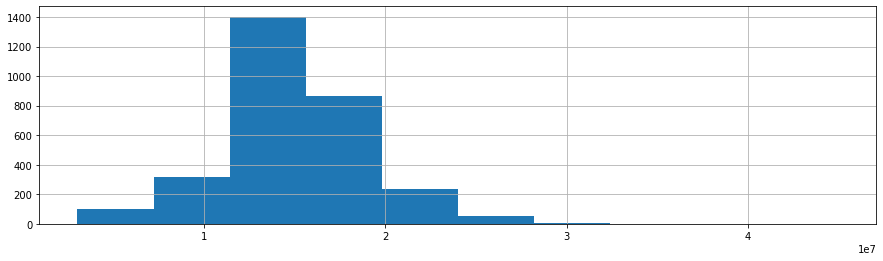

In [502]:
plt.figure(figsize=(15,4))
data[data.rooms==1].price.hist()

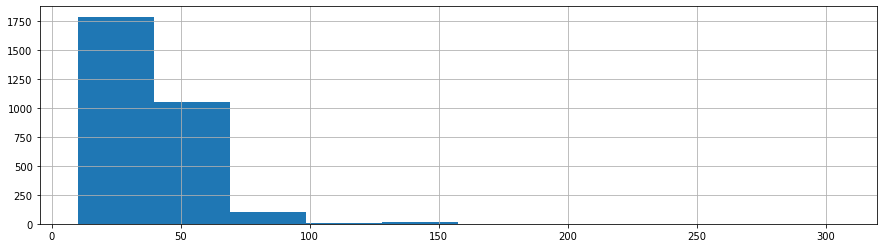

In [367]:
plt.figure(figsize=(15,4))
data[data.rooms==3].price.hist()

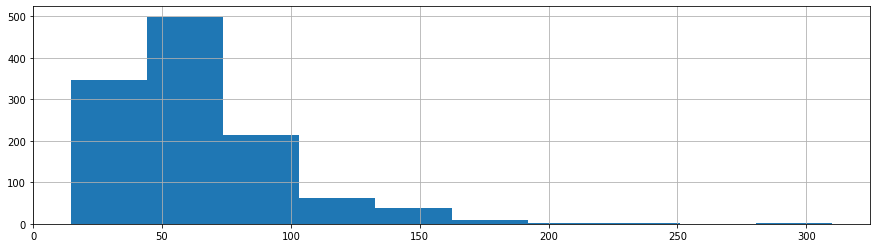

In [368]:
plt.figure(figsize=(15,4))
data[data.rooms==4].price.hist()

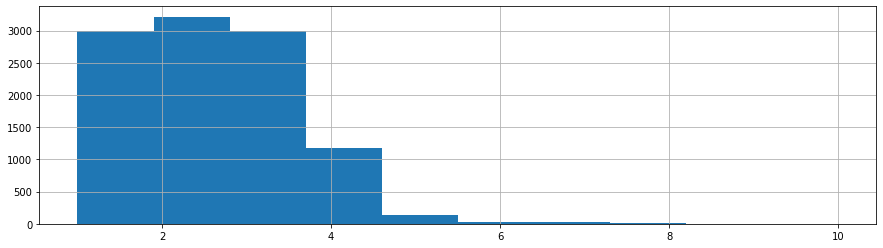

In [372]:
plt.figure(figsize=(15,4))
data.rooms.hist()

# Modeling

In [712]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [598]:
scaler = StandardScaler()

In [587]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10534 entries, 1 to 10801
Data columns (total 11 columns):
renovation        10534 non-null object
year_built        10534 non-null int64
ceiling           10534 non-null float64
rooms             10534 non-null int64
price             10534 non-null float64
square_total      10534 non-null int64
square_living     10534 non-null float64
square_kitchen    10534 non-null float64
floor_flat        9801 non-null float64
floors_total      9615 non-null float64
house_age         10534 non-null int64
dtypes: float64(6), int64(4), object(1)
memory usage: 1.3+ MB


In [626]:
data_renovation = pd.get_dummies(data["renovation"])

In [627]:
df = pd.concat([data, data_renovation], axis=1).drop("renovation", axis=1)

In [638]:
df = df[df.price<150]

In [639]:
X = df.drop("price", axis=1)
y = df["price"]

In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8360, 15) (2091, 15) (8360,) (2091,)


In [641]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [642]:
m_linear = LinearRegression()
model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

In [643]:
model.fit(X_train, y_train)
# m_linear.fit(X_train_scaled, y_train)

0:	learn: 14.0452323	total: 5.3ms	remaining: 5.3ms
1:	learn: 13.4515322	total: 9.01ms	remaining: 0us


In [644]:
def model_scores(modelName):
    y_pred = modelName.predict(X_test)
    mse = "\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test))
    rmse = "\nMSE: {:.4f}".format(math.sqrt(mean_squared_error(y_pred, y_test)))
    return mse, rmse

In [645]:
model_scores(model)

('\nMSE: 190.1954', '\nMSE: 13.7911')

In [652]:
y_pred = model.predict(X_test)

In [716]:
result = pd.DataFrame([y_pred, y_test.values]).T
result.columns = ["actual", "predicted"]
result = result.reset_index()
result = pd.melt(result, id_vars=["index"], value_vars=["actual", "predicted"])

In [717]:
result = result.sort_values(by="index").head(50)

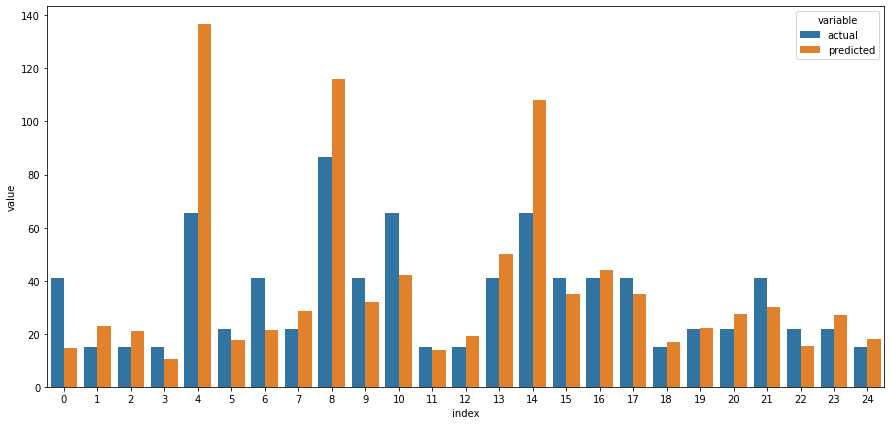

In [719]:
plt.figure(figsize=(15,7))
sns.barplot(x="index", hue="variable", y="value", data=result)